In [1]:
##Reading in wildire data

In [3]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import sys

In [4]:
sys.path[0]+'/../Datasets/FPA_FOD_20170508.sqlite'

'C:\\Users\\payal\\Anaconda4\\python36.zip/../Datasets/FPA_FOD_20170508.sqlite'

In [5]:
conn = sqlite3.connect('../../188-million-us-wildfires/FPA_FOD_20170508.sqlite')

In [6]:
data_dates = pd.read_sql_query("SELECT fire_year, discovery_date FROM fires;", conn)
data_size = pd.read_sql_query("SELECT fire_size, fire_size_class FROM fires;", conn)
data_location = pd.read_sql_query("SELECT latitude, longitude, state FROM fires;", conn)
date = pd.read_sql_query("select datetime(DISCOVERY_DATE) as DISCOVERY_DATE from fires;", conn)

In [7]:
data_dates_arr = date['DISCOVERY_DATE']
fire_year_arr = data_dates['FIRE_YEAR']
fire_size_arr = data_size['FIRE_SIZE']

In [10]:
#Create a dataframe df 
df = data_location
df['date'] = data_dates_arr
df['fire_size'] = fire_size_arr
df['year'] = fire_year_arr
#Converted Lat and Long to int to remove the exact precision
df['LATITUDE'] = df['LATITUDE'].astype(int)
df['LONGITUDE'] = df['LONGITUDE'].astype(int)

In [11]:
#Gives largest wildfires in a location.
new_df = df.sort_values('fire_size', ascending=False).drop_duplicates(['LATITUDE','LONGITUDE'])
new_df.loc[new_df['STATE'] == 'AK', 'fire_size'].sum()
df_AK = new_df.query("STATE == 'AK'")

In [12]:
##Get coords of Alaska
lat_max = df_AK['LATITUDE'].max()
lat_min = df_AK['LATITUDE'].min()
long_max = df_AK['LONGITUDE'].max()
long_min = df_AK['LONGITUDE'].min()

In [13]:
###MOST wildfires, more than 50% has occured in year 2004 and 2005 in AK
print("Out of total wildfires... 2004 had 15 wirefiles and damage is: ", df_AK.query( "year == 2004")['fire_size'].sum())
print("Out of total wildfires... 2005 had 15 wirefiles and damage is: ", df_AK.query( "year == 2005")['fire_size'].sum())

Out of total wildfires... 2004 had 15 wirefiles and damage is:  4933454.6
Out of total wildfires... 2005 had 15 wirefiles and damage is:  2783600.1999999997


In [15]:
df_AK_year = df_AK.groupby('year').agg({'fire_size':sum})
df_AK_year.to_csv('AK_fire.csv')

In [16]:
###Now read in the Temperature data and process it.

In [17]:
import os 
import numpy as np
import iris   
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline
import iris.coord_categorisation as cat
import pandas as pd

In [35]:
#DATASET downloaded from https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.surface.html
PATH = os.path.join(os.getcwd(), "../../air.mon.mean.nc")

In [36]:
cube = iris.load_cube(PATH)

In [37]:
cube.shape

(865, 360, 720)

In [38]:
def region_based_cube(cube,lat_max,lat_min,long_max,long_min):
    '''
    Inputs:
        cube with latitude and longitude as coords
    '''
    lat_cons = iris.Constraint(latitude = lambda x : lat_min < x < lat_max)
    if (long_min<0):
        long_min = long_min+360
    if(long_max <0) :
        long_max = long_max+360
    long_cons = iris.Constraint(longitude = lambda x : long_min < x < long_max)
    new_cube = cube.extract(lat_cons & long_cons)
    return new_cube

In [45]:
##Adding auxilary axis:
def get_decade(coord, value):
    date = coord.units.num2date(value)
    return date.year - date.year % 10
def get_year(coord, value):
    date = coord.units.num2date(value)
    return date.year

def get_month(coord, value):
    date = coord.units.num2date(value)
    return date.month

cat.add_categorised_coord(cube, 'year', 'time', get_year)
#cat.add_categorised_coord(cube, 'month', 'time', get_month)
#cat.add_categorised_coord(cube, 'decade', 'time', get_decade)

ValueError: A coordinate "year" already exists in the cube.

In [46]:
cube_AK = region_based_cube(cube,lat_max,lat_min, long_max, long_min)

In [47]:
##Find the maximum temperature in the specified region
cube_AK_max = cube_AK.collapsed(['latitude','longitude'], iris.analysis.MAX)

C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
C:\Users\payal\Anaconda4\lib\site-packages\iris\coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


In [48]:
cube_AK_max_year = cube_AK_max.aggregated_by(['year'],iris.analysis.MAX)

In [49]:
#Same year range
cube_AK_max_year.coord('year')[-29:-5]

AuxCoord(array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015]), standard_name=None, units=Unit('1'), long_name='year', attributes={'actual_range': array([1297320., 1928472.]), 'avg_period': '0000-01-00 00:00:00', 'coordinate_defines': 'start', 'delta_t': '0000-01-00 00:00:00'})

In [50]:
temp_max_ak = cube_AK_max_year[-29:-5].data

In [61]:
temp_max_ak

array([291.08   , 292.09   , 292.8    , 291.04   , 290.85   , 291.42   ,
       292.42   , 290.48   , 290.31   , 290.16   , 290.51   , 290.95004,
       292.85   , 290.81   , 290.76004, 292.13   , 290.07   , 292.36   ,
       291.16   , 291.06   , 292.25   , 292.18   , 290.04   , 290.78   ],
      dtype=float32)

In [74]:
fire_ak = df_AK_year['fire_size'].tolist()

In [75]:
fire_ak

[48407.0,
 99522.1,
 24670.0,
 3969.0,
 105691.7,
 1641286.0,
 2.2,
 117571.0,
 238581.0,
 117030.8,
 1091160.0,
 410365.1000000001,
 4933454.6,
 2783600.1999999997,
 53850.0,
 353770.0999999999,
 221.7,
 1440466.9000000001,
 291966.37,
 86526.1,
 65805.8,
 694843.9,
 199611.30000000002,
 1853514.6]

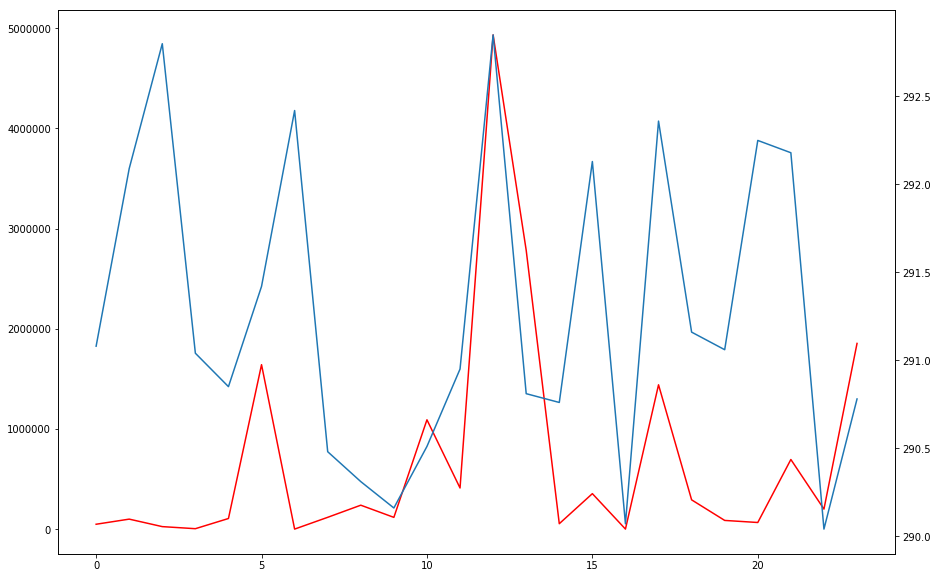

In [77]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
ax1.plot(fire_ak,color='r')
ax2.plot(temp_max_ak)